<a href="https://colab.research.google.com/github/gulssumm/MachineLearningCamp/blob/main/ML_Gulsum_Cetinozlu_Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'books-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4200521%2F7250132%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240919%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240919T171941Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6457a92a7d19a9277432ac403a35b7004fbf9ff31a0c60a4200ac6dc72e3102ecdbbdf4312b6f4c8569be9cd8774ce81eb7d16e83995ebe8796ae53f04a04ba04bc0f8091702a87ce9bb524547eac025b5fd6a5eadf8ec41894f77cf02fd9306cbaaf13ef291dc829d856e684d6b3619acc5ccd7b0eb486d1c539bd8765fa0c869b49296bec154321f1de9320ef76714e0ebac5c24b2428d4f5eb04e4d661d934d7fd827247ae33ff534be709a49118e4426ff529da65639d66f9b4234937f238af7374153be6cff167099dff94368c93d4539ab92f767da35c79ceb83a1501cf4b7aeceb68e46cb5a5c6fbfa4d4836c8784b924ed5156b99faa60ddaa697ac5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 55469565 bytes downloaded
Downloaded and uncompressed: books-dataset
Data source import complete.


In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/books-dataset/BooksDatasetClean.csv
/kaggle/input/books-dataset/BooksDataset.csv


# Quick Preperation of the Dataset

In [17]:
data = pd.read_csv("/kaggle/input/books-dataset/BooksDataset.csv")
data.isnull().sum()

,0
Title,0
Authors,0
Description,32869
Category,26170
Publisher,8
Publish Date,0
Price,0


In [18]:
# Fill missing 'Description', 'Category', and 'Publisher' with 'Unknown'
data['Description'].fillna('Unknown', inplace=True)
data['Category'].fillna('Unknown', inplace=True)
data['Publisher'].fillna('Unknown', inplace=True)

In [19]:
data.isnull().sum()

,0
Title,0
Authors,0
Description,0
Category,0
Publisher,0
Publish Date,0
Price,0


In [20]:
# Extract numeric part of Price (assuming 'Price Starting at $5.29' format)
data['Price'] = data['Price'].str.extract(r'(\d+\.\d+)').astype(float)

# Unsupervised Learning

## K-means Clustering

In [21]:
data.columns

Index(['Title', 'Authors', 'Description', 'Category', 'Publisher',
       'Publish Date', 'Price'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


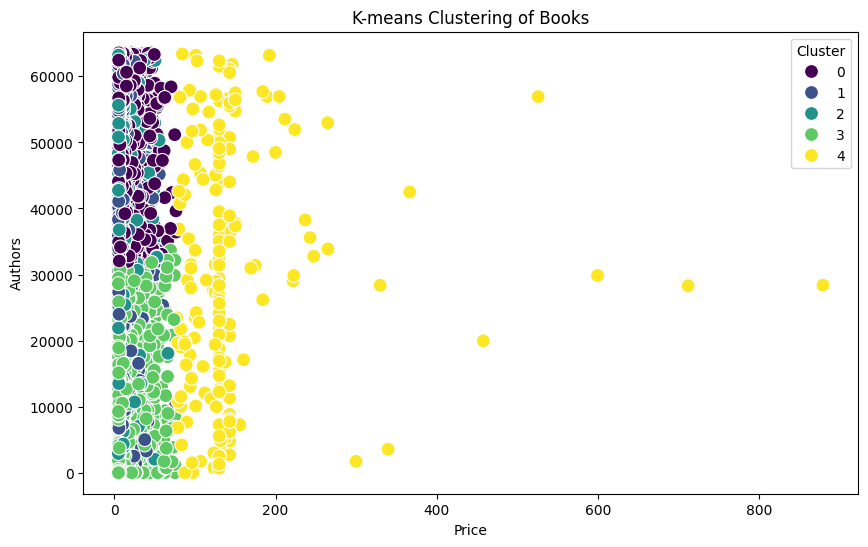

In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Features for clustering
features = ['Price', 'Authors', 'Category', 'Publisher']

# Encode categorical features
label_encoders = {}
for column in ['Authors', 'Category', 'Publisher']:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Extract the feature matrix
X = data[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # number of clusters
kmeans.fit(X_scaled)

# Add cluster labels to the data
data['Cluster'] = kmeans.labels_

# Plot the clusters (example using Price and Authors)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Price'], y=data['Authors'], hue=data['Cluster'], palette='viridis', s=100)
plt.title('K-means Clustering of Books')
plt.show()

# Improvement

## Log Transformation of Price

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


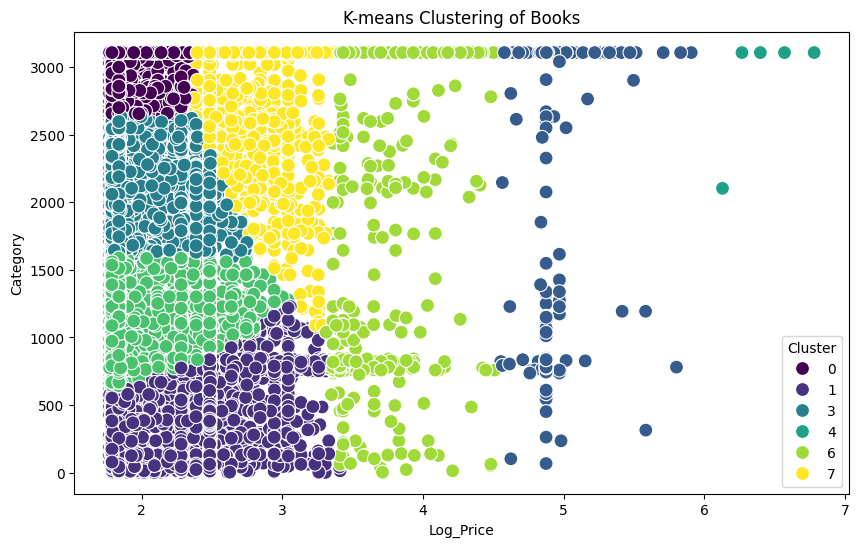

In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Apply log transformation to 'Price' to handle skewness
data['Log_Price'] = np.log1p(data['Price'])  # log(1 + price) to handle zero prices

# Features for clustering
features = ['Price', 'Category']

# Extract the feature matrix
X = data[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
kmeans = KMeans(n_clusters=8, random_state=42)  # number of clusters
kmeans.fit(X_scaled)

# Add cluster labels to the data
data['Cluster'] = kmeans.labels_

# Plot the clusters (example using Price and Authors)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Log_Price'], y=data['Category'], hue=data['Cluster'], palette='viridis', s=100)
plt.title('K-means Clustering of Books')
plt.show()

## Model Evaluation

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
import numpy as np

# Initialize variables
n_splits = 5  # Number of folds for cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
silhouette_scores = []

# Apply KFold cross-validation
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]

    # Apply K-means clustering to the train data
    kmeans = KMeans(n_clusters=8, random_state=42)  # You can adjust the number of clusters
    kmeans.fit(X_train)

    # Predict the clusters for test data
    labels = kmeans.predict(X_test)

    # Calculate the silhouette score for the test data
    score = silhouette_score(X_test, labels)
    silhouette_scores.append(score)

# Calculate the average silhouette score
avg_silhouette_score = np.mean(silhouette_scores)

# Output the results
print(f"Silhouette Scores for each fold: {silhouette_scores}")
print(f"Average Silhouette Score: {avg_silhouette_score}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Silhouette Scores for each fold: [0.5164488719469142, 0.5404159662452475, 0.5422671970951595, 0.5373777055169642, 0.545220299684004]
Average Silhouette Score: 0.5363460080976579


## Deductions
* Silhouette scores are consistent, and the average score of 0.536
* The clusters are well separated